In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split,LeaveOneOut
import seaborn as sns
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn import metrics
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv("shen_268_parcellation_networklabels.csv",encoding="utf-8")
filePath = 'D:\jupyter_psychology\Shen268\ROI_FC_r_per\session1'
filePath_list = os.listdir(filePath)
pca_alg = PCA(n_components = 1, whiten=True)
num = [29,34,20,90,50,18,9,18]
num1 = [0,29,63,83,173,223,241,250,268]
net = [10,12,16,52,53,54,56,57,64,65,137,140,145,148,149,150,151,153,156,162,165,183,185,186,187,190,192,194,219,
      1,4,7,8,9,14,17,19,21,22,30,31,47,48,55,70,111,112,116,139,142,143,147,154,157,164,182,184,193,196,199,242,246,247,
      3,5,6,13,49,50,85,86,90,96,115,134,138,141,203,222,223,225,227,239,
      2,11,15,18,20,28,29,32,36,44,83,88,91,93,94,95,99,101,103,104,105,106,107,108,110,113,114,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,135,136,144,146,152,155,169,178,217,220,221,224,226,229,230,231,232,233,234,236,237,238,243,244,245,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,
      23,24,25,26,27,33,34,35,37,38,39,40,45,46,51,58,60,61,62,63,84,89,92,97,109,158,159,160,161,163,166,167,168,170,171,172,173,174,179,180,181,188,189,191,195,197,202,218,228,235,
      42,68,72,75,77,79,80,82,87,98,176,198,205,207,208,211,215,216,
      76,78,81,100,102,212,213,214,241,
      41,43,59,66,67,69,71,73,74,175,177,200,201,204,206,209,210,240]

In [3]:
train_Y = []
train_X = np.empty(shape=[0,1082],dtype=float)

for fp in filePath_list:
    fp_a = ['D:\jupyter_psychology\Shen268\ROI_FC_r_per\session1\\'+fp,'D:\jupyter_psychology\Shen268\ROI_FC_r_per\session2\\'+fp,'D:\jupyter_psychology\Shen268\ROI_FC_r_per\session3\\'+fp]
    train_Y = np.append(train_Y,[0,1,2],axis=0)
    for s in range(3):
        data =  np.loadtxt(fp_a[s])
        #print(data)
        tmp = np.empty(shape=[0,268],dtype=float)
        #行排列
        for i in range(268):
            tmp = np.append(tmp,[data[net[i]-1,:]],axis=0)
        data =  np.empty(shape=[0,268],dtype=float)
        #列排列，8*8网络
        for i in range(268):
            data = np.append(data,[tmp[:,net[i]-1]],axis=0)
        #print(data)
        net_cnct = []
        for i in range(8):
            for j in range(i+1):
                network = data[num1[i]:num1[i+1],num1[j]:num1[j+1]]
                network = pca_alg.fit_transform(network)
                network = network.ravel()
                net_cnct.extend(list(network))
        train_X = np.append(train_X,[np.array(net_cnct)],axis=0)
    #break;

In [4]:
import seaborn as sns
from sklearn.model_selection import KFold
X = np.arange(0,201,3)
num = [29,34,20,90,50,18,9,18]
num1 = [0,29,63,83,173,223,241,250,268]
df = pd.read_csv("shen_268_parcellation_networklabels.csv",encoding="utf-8")
net_name = ['medial frontal','frontoparietal','default mode','subcortical-cerebellum','motor','visual I','visual II','visual association']
sum_acc = 0
sum_pre = 0
sum_rec = 0
sum_f1 = 0
total_importance = []   

loo = LeaveOneOut()
for train_index , test_index in loo.split(X):  # 调用split方法切分数据
    train_x = train_X[X[train_index]]
    train_y = train_Y[X[train_index]]
    train_x = np.append(train_x,train_X[X[train_index]+1],axis=0)
    train_y = np.append(train_y,train_Y[X[train_index]+1],axis=0)
    train_x = np.append(train_x,train_X[X[train_index]+2],axis=0)
    train_y = np.append(train_y,train_Y[X[train_index]+2],axis=0)
    test_x = train_X[X[test_index]]
    test_y = train_Y[X[test_index]]
    test_x = np.append(test_x,train_X[X[test_index]+1],axis=0)
    test_x = np.append(test_x,train_X[X[test_index]+2],axis=0)
    test_y = np.append(test_y,train_Y[X[test_index]+1],axis=0)
    test_y = np.append(test_y,train_Y[X[test_index]+2],axis=0)
    

    dtrain = xgb.DMatrix(train_x,label=train_y)
    ddtrain = xgb.DMatrix(train_x)
    dtest = xgb.DMatrix(test_x,label=test_y)
    ddtest = xgb.DMatrix(test_x)
    watchlist = [(dtrain,'train'),(dtest,'test')]
    
    best_depth = 3
    best_score = 0
    best_weight = 3
    for max_depth in range(3,10):
        for min_child_weight in range(3,10):
            param = {'booster':'gbtree',
                'objective': 'multi:softmax',
                'eval_metric': 'mlogloss',#,'auc'
                'num_class':3,
                'max_depth':max_depth,
                'lambda':10,
                'subsample':0.8,
                'colsample_bytree':0.9,
                'min_child_weight':min_child_weight,
                'eta': 0.01,
                'seed':0,
                'nthread':8,
                'gamma':0.6,
                'reg_alpha': 1e-05,
                'learning_rate' : 0.1}
            bst=xgb.train(param,dtrain,early_stopping_rounds=10, num_boost_round=500,evals=watchlist,verbose_eval=False)
            pred_test_y = bst.predict(ddtest)
            score = accuracy_score(test_y, pred_test_y)
            if score > best_score:
                best_score = score
                best_depth = max_depth
                best_weight = min_child_weight
                #print(best_depth)
    # booster:
    param = {'booster':'gbtree',
            'objective': 'multi:softmax',
            'eval_metric': 'mlogloss',#,'auc'
            'num_class':3,
            'max_depth':best_depth,
            'lambda':10,
            'subsample':0.8,
            'colsample_bytree':0.9,
            'min_child_weight':best_weight,
            'eta': 0.01,
            'seed':0,
            'nthread':8,
            'gamma':0.6,
            'reg_alpha': 1e-05,
            'learning_rate' : 0.1}
    bst=xgb.train(param,dtrain,early_stopping_rounds=10, num_boost_round=500,evals=watchlist,verbose_eval=False)
    
    pred_test_y = bst.predict(ddtest)
    sum_acc += metrics.accuracy_score(test_y,pred_test_y)
    sum_pre += metrics.precision_score(test_y,pred_test_y,average='macro')
    sum_rec += metrics.recall_score(test_y,pred_test_y,average='macro')
    sum_f1 += metrics.f1_score(test_y,pred_test_y,average='macro')
    
    df = pd.read_csv("shen_268_parcellation_networklabels.csv",encoding="utf-8")

    net_importance =  np.zeros((8,8))
    Node_importance = bst.get_score(fmap='',importance_type='weight')
    index = 0
    total = 0
    for i in range(8):
        for j in range(i+1):
            sum_importance = 0
            for k in range(num[i]):
                if 'f'+str(index) in Node_importance.keys():
                    sum_importance += Node_importance['f'+str(index)]
                index += 1
            net_importance[i][j] = sum_importance/num[i]
            total += net_importance[i][j]
    for i in range(8):
        for j in range(i+1):
            net_importance[i][j] = net_importance[i][j]/total
    total_importance.append(net_importance)
    

D:\WorkApp\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\WorkApp\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\WorkApp\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\WorkApp\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precis

In [5]:
print(sum_acc/67,sum_pre/67,sum_rec/67,sum_f1/67)

0.6467661691542288 0.5290215588723051 0.6467661691542288 0.5663349917081263


In [6]:
all_im = []
for k in range(67):
    k_im = np.zeros(36)
    cnt = 0
    for i in range(8):
        for j in range(i+1):
            k_im[cnt] = total_importance[k][i][j]
            cnt += 1
    all_im.append(k_im)
with open('67net_importance_Xgboost8v28.txt', 'a') as f:
    for k in range(67):
        for i in range(8):
            for j in range(i+1):
                tmp = str(total_importance[k][i][j])
                tmp += '\n'
                f.write(tmp)
with open('67net_importance_Xgboost8v8.txt', 'a') as f:
    for k in range(67):
        for i in range(8):
            tmp = str(total_importance[k][i][i])
            tmp += '\n'
            f.write(tmp)
        tmp = str((all_im[k][2]+all_im[k][4]+all_im[k][7]+all_im[k][11]+all_im[k][16]+all_im[k][22]+all_im[k][29])/7)
        print(tmp)
        tmp += '\n'
        f.write(tmp)
        tmp = str((all_im[k][2]+all_im[k][5]+all_im[k][8]+all_im[k][12]+all_im[k][17]+all_im[k][23]+all_im[k][30])/7)
        tmp += '\n'
        f.write(tmp)
        tmp = str((all_im[k][4]+all_im[k][5]+all_im[k][9]+all_im[k][13]+all_im[k][18]+all_im[k][24]+all_im[k][31])/7)
        tmp += '\n'
        f.write(tmp)
        tmp = str((all_im[k][7]+all_im[k][8]+all_im[k][9]+all_im[k][14]+all_im[k][19]+all_im[k][25]+all_im[k][32])/7)
        tmp += '\n'
        f.write(tmp)
        tmp = str((all_im[k][11]+all_im[k][12]+all_im[k][13]+all_im[k][14]+all_im[k][20]+all_im[k][26]+all_im[k][33])/7)
        tmp += '\n'
        f.write(tmp)
        tmp = str((all_im[k][16]+all_im[k][17]+all_im[k][18]+all_im[k][19]+all_im[k][20]+all_im[k][27]+all_im[k][34])/7)
        tmp += '\n'
        f.write(tmp)
        tmp = str((all_im[k][22]+all_im[k][23]+all_im[k][24]+all_im[k][25]+all_im[k][26]+all_im[k][27]+all_im[k][35])/7)
        tmp += '\n'
        f.write(tmp)
        tmp = str((all_im[k][29]+all_im[k][30]+all_im[k][31]+all_im[k][32]+all_im[k][33]+all_im[k][34]+all_im[k][35])/7)
        tmp += '\n'
        f.write(tmp)
    f.close()

0.02423284886141065
0.01569109894028568
0.022889555461491167
0.025037114646161856
0.022220338428997732
0.01816460695953027
0.023386940505444927
0.028179805309921174
0.024110453486890858
0.02336993897705553
0.015884886146548184
0.020557723600228277
0.02311212367635119
0.01899042656119439
0.018531423561989283
0.020101077889380377
0.021027525998251296
0.016936237265400375
0.01849952634904819
0.021545230581089796
0.017811614849342187
0.014629771316566379
0.02406890938474954
0.016903566909926098
0.02295780034087354
0.02318189988930188
0.022085447849813145
0.01848014242538499
0.020297158009694897
0.024648097332208237
0.018206609591928817
0.02422205847203596
0.025052484176208454
0.02500837592603831
0.024042687340579547
0.03343325026861329
0.018033800170945035
0.019816638000740565
0.022290543550653318
0.023073741855707156
0.02160294534792982
0.024984356976456144
0.024788723632377958
0.017117154993043362
0.023779582034448316
0.022590890380775
0.02572604497273558
0.021885003911763144
0.022065692

In [9]:
import math
cnt = 0
net_importance = np.zeros((8,8))
net_variance = np.zeros(36)
net_score = np.zeros(36)
for i in range(8):
    for j in range(i+1):
        for k in range(67):
            net_score[cnt] += total_importance[k][i][j]
        net_score[cnt] /= 67
        net_importance[i][j] = net_score[cnt]
        cnt+=1
cnt = 0
for i in range(8):
    for j in range(i+1):
        for k in range(67):
            net_variance[cnt] += math.pow((total_importance[k][i][j] - net_score[cnt]),2)
        net_variance[cnt] /= 67
        net_variance[cnt] = math.sqrt(net_variance[cnt])
        cnt+=1

print(net_score)
print(net_variance)

[0.03277693 0.04586738 0.02514115 0.03652738 0.02380188 0.04099528
 0.02599127 0.01973355 0.03792506 0.03434358 0.0165177  0.02546491
 0.03111074 0.02326287 0.02092196 0.02433122 0.02481795 0.03839898
 0.01632339 0.04008041 0.04158933 0.02170443 0.02092155 0.01662529
 0.02047304 0.03744779 0.02422625 0.02174459 0.04286507 0.01424936
 0.01520346 0.03523826 0.02974106 0.01602019 0.04455095 0.01306581]
[0.01178657 0.00937459 0.00691635 0.00950432 0.0108343  0.01029279
 0.00403449 0.0045703  0.00701526 0.00435003 0.00536181 0.0066883
 0.00855307 0.00739858 0.00563851 0.0082025  0.00912568 0.01708022
 0.00804211 0.01255006 0.01236861 0.01374628 0.0158179  0.01180679
 0.01253686 0.01802171 0.01299278 0.01041927 0.01181447 0.00774042
 0.00742041 0.01028483 0.00978348 0.00924769 0.01069449 0.00799894]


In [8]:
with open('net_importance_Xgboost8v28.txt', 'a') as f:
    for k in range(36):
        tmp = str(net_score[k])
        tmp += '\n'
        f.write(tmp)
with open('net_importance_Xgboost8v8.txt', 'a') as f:
    for i in range(8):
        tmp = str(net_importance[i][i])
        tmp += '\n'
        f.write(tmp)
    tmp = str((net_score[2]+net_score[4]+net_score[7]+net_score[11]+net_score[16]+net_score[22]+net_score[29])/7)
    tmp += '\n'
    f.write(tmp)
    tmp = str((net_score[2]+net_score[5]+net_score[8]+net_score[12]+net_score[17]+net_score[23]+net_score[30])/7)
    tmp += '\n'
    f.write(tmp)
    tmp = str((net_score[4]+net_score[5]+net_score[9]+net_score[13]+net_score[18]+net_score[24]+net_score[31])/7)
    tmp += '\n'
    f.write(tmp)
    tmp = str((net_score[7]+net_score[8]+net_score[9]+net_score[14]+net_score[19]+net_score[25]+net_score[32])/7)
    tmp += '\n'
    f.write(tmp)
    tmp = str((net_score[11]+net_score[12]+net_score[13]+net_score[14]+net_score[20]+net_score[26]+net_score[33])/7)
    tmp += '\n'
    f.write(tmp)
    tmp = str((net_score[16]+net_score[17]+net_score[18]+net_score[19]+net_score[20]+net_score[27]+net_score[34])/7)
    tmp += '\n'
    f.write(tmp)
    tmp = str((net_score[22]+net_score[23]+net_score[24]+net_score[25]+net_score[26]+net_score[27]+net_score[35])/7)
    tmp += '\n'
    f.write(tmp)
    tmp = str((net_score[29]+net_score[30]+net_score[31]+net_score[32]+net_score[33]+net_score[34]+net_score[35])/7)
    tmp += '\n'
    f.write(tmp)
    f.close()

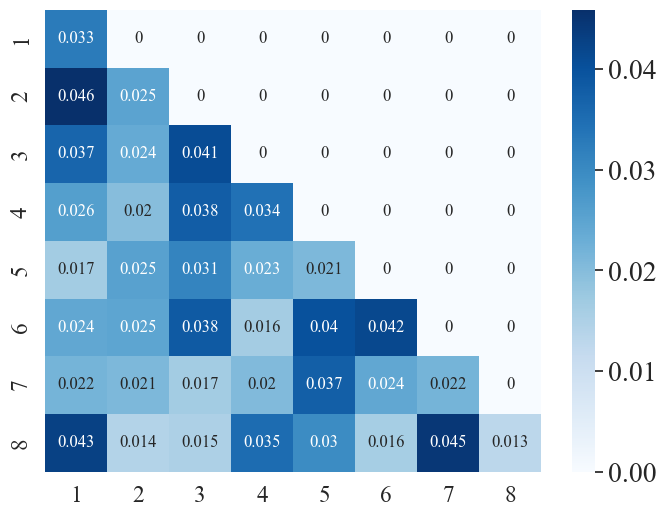

"\nplt.figure(figsize=(8, 6))\nplt.scatter(net_score,net_variance)\nfor i, name in enumerate(['a11','a21','a22','a31','a32','a33','a41','a42','a43','a44','a51','a52','a53','a54','a55','a61','a62','a63','a64','a65','a66',\n                          'a71','a72','a73','a74','a75','a76','a77','a81','a82','a83','a84','a85','a86','a87','a88']):\n    plt.annotate(name,(net_score[i],net_variance[i]))\nplt.title('Xgboost Scatter Plot',fontsize='xx-large',fontweight='heavy')\nplt.xlabel('Importance Score',fontsize=16)\nplt.ylabel('Standard Deviation',fontsize=16)\n\nx_line = np.linspace(0.00,0.06)\ny_line = x_line\nplt.plot(x_line, y_line, 'r--')\nplt.show()\n"

In [16]:
#x_ticks = ['medial frontal','frontoparietal','default mode','subcortical-cerebellum','motor','visual I','visual II','visual association']
#y_ticks = ['medial frontal','frontoparietal','default mode','subcortical-cerebellum','motor','visual I','visual II','visual association']
x_ticks = ['1','2','3','4','5','6','7','8']
y_ticks = ['1','2','3','4','5','6','7','8']
plt.figure(figsize=(8, 6))
sns.heatmap(net_importance,xticklabels=x_ticks, yticklabels=y_ticks, annot=True, cmap='Blues')#, linewidths=.5
sns.set_theme(style="whitegrid",font='Times New Roman',font_scale=1.4)
plt.xticks(fontsize=20,font='Times New Roman')
plt.yticks(fontsize=20,font='Times New Roman')
#设置colorbar的刻度字体大小
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=20)
plt.savefig('Xgboost_Heatmap.png', dpi=600, bbox_inches='tight')
plt.show()
'''
plt.figure(figsize=(8, 6))
plt.scatter(net_score,net_variance)
for i, name in enumerate(['a11','a21','a22','a31','a32','a33','a41','a42','a43','a44','a51','a52','a53','a54','a55','a61','a62','a63','a64','a65','a66',
                          'a71','a72','a73','a74','a75','a76','a77','a81','a82','a83','a84','a85','a86','a87','a88']):
    plt.annotate(name,(net_score[i],net_variance[i]))
plt.title('Xgboost Scatter Plot',fontsize='xx-large',fontweight='heavy')
plt.xlabel('Importance Score',fontsize=16)
plt.ylabel('Standard Deviation',fontsize=16)

x_line = np.linspace(0.00,0.06)
y_line = x_line
plt.plot(x_line, y_line, 'r--')
plt.show()
'''

In [10]:
net_between = 0
net_within = 0
for i in range(8):
    for j in range(i):
        net_between += net_importance[i][j]
for i in range(8):
    net_within += net_importance[i][i]
print(net_between,net_within)
print(net_between/28,net_within/8)

print(((net_between/28)/(net_within/8)))
print(sum_acc/67,sum_pre/67,sum_rec/67,sum_f1/67)

0.7694213714572007 0.2305786285427994
0.027479334694900024 0.028822328567849925
0.9534043937571389
0.6467661691542288 0.5290215588723051 0.6467661691542288 0.5663349917081263


In [11]:
for i in range(8):
    x = 0
    for j in range(8):
        x += net_importance[i][j]
    print(x)

0.03277692844119093
0.07100853244805211
0.10132452919781093
0.11799345823116364
0.11727817804399564
0.18554127649823315
0.1631429417367941
0.2109341554027595
